 # Homework: mission profile analysis 
 
The objective of this homework is to analyze a mission profile allowing the selection of a motor/reducer assembly. The steps to follow are as follows:
- generation of a kinematic mission profile (position, speed, acceleration, etc.) meeting application constraints
- calculation of dynamic efforts corresponding to this kinematic profile using a load model
- calculation of equivalent quantities enabling the selection of components

The case study in this notebook is the motorisation of an electric cable lift. 

![Cable Car](./assets/images/CableCar.png)

### Position and speed mission profile

A mission profile meeting the following criteria has been constructed. It will be assumed that it represents typical movements of the lift car, continuously repeated 8 hours a day for 10 years (i.e. a service life of 30,000 hours).

| Dynamic criteria      |        |
|---    |:-:    |
| Max. Acceleration      | $1 m/s^2$      | 
| Max. Speed      | $2 m/s$      | 
| Max. Load      |  $2.5 m/s^3$     | 


This profile, saved in an Excel file, is read in the form of a [dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) (from the [pandas](https://pandas.pydata.org/) package). 

In [167]:
import pandas as pd

df = pd.read_excel('ElevatorMission.xlsx')

df.head()

,Time,Position,Speed,Acceleration,Jerk
0,0.0,0.000000,0.0000,0.00,2.5
1,0.1,0.000475,0.0125,0.25,2.5
2,0.2,0.003504,0.0500,0.50,2.5
3,0.3,0.011472,0.1125,0.75,2.5
4,0.4,0.026889,0.2000,1.00,2.5


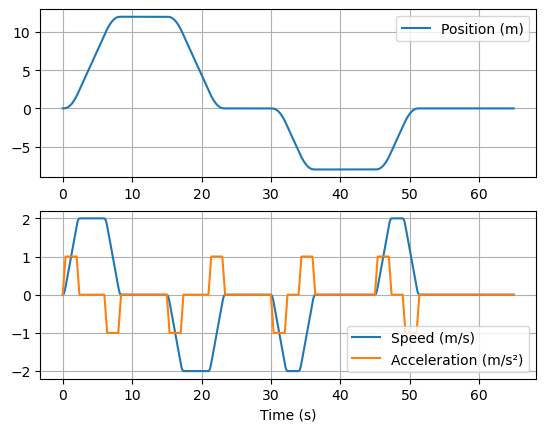

In [168]:
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import numpy as np

t, X, Xp, Xpp = np.array(df.Time), np.array(df.Position), np.array(df.Speed),np.array(df.Acceleration)

plt.figure(1)
plt.subplot(211)
plt.plot(t, X, label='Position (m)')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(t, Xp, label='Speed (m/s)')
plt.plot(t, Xpp, label='Acceleration (m/s²)')
plt.legend()
plt.xlabel('Time (s)')
plt.grid()

### Torque mission profile

We will assume here that we are studying a lift equivalent to the following mechanical load:
- a cabin/car of variable mass according to the load: 400 kg empty, 800 kg fully loaded;
- a 600 kg counterweight;
- a pulley with a diameter of 70 cm, an inertia of 10 kg.m².

The motorization will be assumed to consist of a reduction assembly with an epicycloidal gear train, permanent magnet motor, inverter, rectifier and braking resistor. 
![Motor reducer set](./assets/images/MotorReducerSet.png)


> **Question 1:** calculate and display the torque given by the reducer and the rotation speed at the pulley.  
> **Question 2:** calculate the maximum torque, the RMC (Root Mean Cube) torque and the mean speed representative of the mechanical fatigue of the gearbox (bearings). What is the most critical cabin mass ?

**Reminder:**   
- Mean speed: $\omega_{mean} = \int_0^t |\omega| dt$  
- Root Mean Cube Torque : $T_{RMC} = \sqrt[3]{ \frac{\int_0^t |T^3\omega| dt}{\omega_{mean}t}} $  

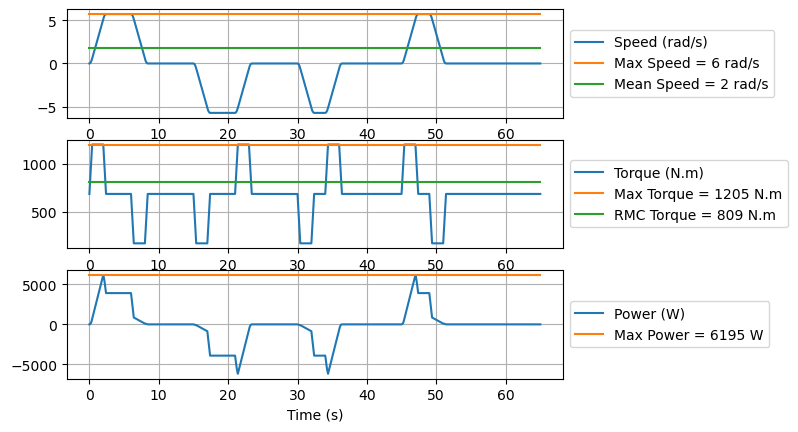

In [169]:
import numpy as np

g=9.8 # [m/s²] gravity constant
Mcar=800 # [kg] Car mass
Mcw=600 # [kg] Counterweight mass 

dpulley=0.7 # [m] Pulley diameter
Jpulley=10 # [kg.m²] Pulley inertia

J=Jpulley + (dpulley/2)**2*(Mcar+Mcw) # [kg.m²] Equivalent inertia

Wreducer=Xp/(dpulley/2) # [rad/s] Reducer speed (high torque side)
Wpreducer=Xpp/(dpulley/2) # [rad/s²] Reducer accelzration (high torque side)

Wmax=np.max(Wreducer) # [rad/s] max speed
Wmean=np.trapz(abs(Wreducer),t)/np.max(t)# [rad/s] mean rolling fatigue speed

Treducer= J*Wpreducer + dpulley/2*g*(Mcar-Mcw) # [N.m] reducer torque
Preducer= Treducer*Wreducer # [W] Power
Pmax=np.max(Preducer) # [W] max power

Trmc=(np.trapz(abs(Treducer**3*Wreducer),t)/np.trapz(abs(Wreducer),t))**(1/3)
Tmax=np.max(abs(Treducer))

plt.figure(1)
plt.subplot(311)
plt.plot(t, Wreducer, label='Speed (rad/s)')
plt.plot(t, Wmax*np.ones(len(t)), label='Max Speed = %.0f rad/s'%Wmax)
plt.plot(t, Wmean*np.ones(len(t)), label='Mean Speed = %.0f rad/s'%Wmean)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.subplot(312)
plt.plot(t, Treducer, label='Torque (N.m)')
plt.plot(t, Tmax*np.ones(len(t)), label='Max Torque = %.0f N.m'%Tmax)
plt.plot(t, Trmc*np.ones(len(t)), label='RMC Torque = %.0f N.m'%Trmc)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.grid()
plt.subplot(313)
plt.plot(t, Preducer , label='Power (W)')
plt.plot(t, Pmax*np.ones(len(t)), label='Max Power = %.0f W'%Pmax)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.grid()

### Gearbox selection

We suppose that we want to select a reducer with reduction ratio $N$=61. The available range presents reducers of different sizes.
![GearBox Catalog](./assets/images/GearBoxCatalog.png)

> **Question 1:** Propose a gearbox that is compatible in terms of torque and maximum speed, and in terms of mechanical fatigue torque.

**Reminder:** The rolling mechanical fatigue of internal gearbox bearings depends on the number of revolutions and therefore on a rated speed which may differ from that of the application. It is possible to relate the rated torque of the gearbox to the torque RMC previously calculated using the following relationship $𝑇_{𝑟𝑎𝑡𝑒𝑑}^3 𝜔_{rated} t=𝑇_{𝑅𝑀𝐶}^3 𝜔_{mean} t$

In [170]:
N=61
WmeanHS=N*Wmean
Trated=Trmc*(WmeanHS/(3000*2*3.14/60))**(1/3)
print("Max torque: %.0f N.m"%Tmax)
print("Max input speed: %.0f rpm"%(Wmax*N/2/3.14*60))
print("Rated torque: %.0f N.m"%Trated)

Max torque: 1205 N.m
Max input speed: 3330 rpm
Rated torque: 566 N.m


AD200, 2 stages, N=61, gearbox seems compatible :
- max Torque = 3 x Nominal torque = 3300 N.m
- max input speed = 6000 rpm 
- nominal Torque = 1100 N.m

### Brushless motor selection

> **Question 1:** Calculate the max torque, max speed and RMS torque at the motor level. Take into account the direct and inverse efficiency of the gearbox in the calculation. Assume the effect of motor inertia negligible.

**Reminders:** Root Mean Square Torque : $T_{RMS} = \sqrt{ \frac{\int_0^T T^2 dt}{T}} $  


Mechanical load =
a cabin/car of variable mass according to the load: 400 kg empty, 1000 kg fully loaded
+ a 700 kg counterweight
+ a pulley with a diameter of 70 cm, an inertia of 10 kg.m², an efficiency of 95%.


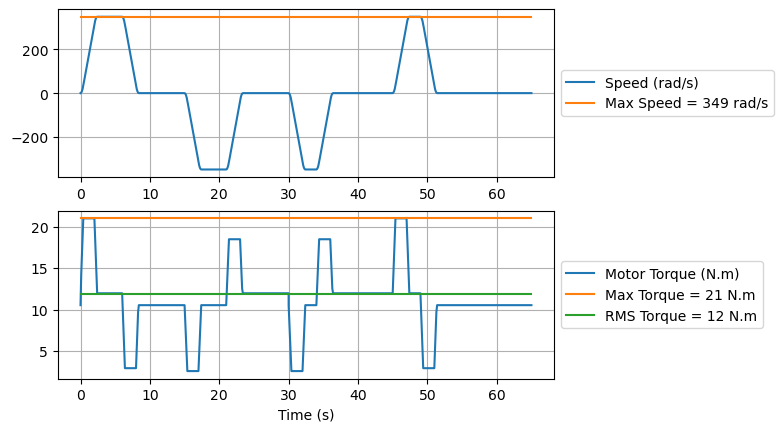

In [171]:
N=61
nu_d=0.94 # [-] gearbox direct efficiency 
nu_i=2-1/nu_d # [-] gearbox inverse efficiency

Wmotor= N*Wreducer # [rad/s] Motor speed 
Wmax_motor=np.max(Wmotor) # [rad/s] Max motor speed

Tmotor = Treducer/N/nu_d*(Preducer>0)+Treducer/N*nu_i*(Preducer<=0) # [N.m] motor torque
Tmax_motor = np.max(Tmotor) # [N.m] max motor torque
Trms=(np.trapz(abs(Tmotor**2),t)/np.max(t))**(1/2) # [N.m] RMS torque


plt.figure(1)
plt.subplot(211)
plt.plot(t, Wmotor, label='Speed (rad/s)')
plt.plot(t, Wmax_motor*np.ones(len(t)), label='Max Speed = %.0f rad/s'%Wmax_motor)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.subplot(212)
plt.plot(t, Tmotor, label='Motor Torque (N.m)')
plt.plot(t, Tmax_motor*np.ones(len(t)), label='Max Torque = %.0f N.m'%Tmax_motor)
plt.plot(t, Trms*np.ones(len(t)), label='RMS Torque = %.0f N.m'%Trms)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.grid()


> **Question 2:** Select a compatible motor in the following catalog.

![GearBox Catalog](./assets/images/BrushlessMotorCatalog.png)

![](.\assets\images\TorqueSpeedCurveBrushlessMotor.png)

> **Question 2:** Compare the application needs, such as RMS torque, max torque, max speed to the following motor characteristic.

![Torque Speed curve](./assets/images/TorqueSpeedCurveBrushlessMotor.png)